# Machine Learning on Graphs

**Authored by Alexandre Mathias DONNAT, Sr - Télécom Paris**

## Tools and library

In this lab we start with the discovery of popular libraries for analysing graphs, namely `scikit-network`, developped here at Télécom Paris,`networkx`, and `torch geometric`.

## Part 1: Graph Manipulation with Scikit-Network

This section introduces basic graph manipulation using the scikit-network library. The following operations are covered:

- Loading the graph dataset using scikit-network
- Inspecting the adjacency and biadjacency matrices
- Visualizing the graph structure
- Computing average node degrees

**Purpose**: To familiarize with fundamental graph structures commonly used in machine learning applications.


In [ ]:
# Installation of the library
!pip install scikit-network

In [2]:
from IPython.display import SVG
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [3]:
from sknetwork.data import load_netset
from sknetwork.visualization import svg_graph

#### Import data

Cora is a directed citation network of 2708 papers with link as citation (citing paper points to cited paper, the order in the edgelist is reversed). Each paper has one label (7 types of label in total). The labels are:

    Case Based
    Genetic Algorithms
    Neural Networks
    Probabilistic Methods
    Reinforcement Learning
    Rule Learning
    Theory

Also, each papers has a binary feature vector of 1433 elements (word existance indicator) describing the content of the node. All nodes has label and feature vector.


In [4]:
cora = load_netset('cora')

Unpacking archive...
Parsing files...
Done.


In [5]:
# Let us take a closer look at the cora object
cora

{'adjacency': <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 5429 stored elements and shape (2708, 2708)>,
 'biadjacency': <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 49216 stored elements and shape (2708, 1433)>,
 'labels': array([2, 2, 1, ..., 6, 6, 6], shape=(2708,)),
 'meta': {'name': 'Cora',
  'source': 'https://relational.fit.cvut.cz/dataset/CORA',
  'description': 'Graph of citations between scientific publications.',
  'long_description': 'Graph of citations between 2708 scientific publications on Machine Learning. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.',
  'date': '2008'},
 'names': array([     35,      40,     114, ..., 1154524, 1154525, 1155073],
       shape=(2708,)),
 'names_labels': array(['Theory', 'Reinforcement Learning', 'Genetic Algorithm

In [6]:
# We can then access to specific elements of the cora object as follow
lab = cora.labels
adj = cora.adjacency

>**To do:** Where are the node features?

In [7]:
# Access the node features
features = cora.biadjacency

# Display information about the features
print("Feature matrix shape:", features.shape)
print("Number of nodes:", features.shape[0])
print("Number of features per node:", features.shape[1])
print("Number of non-zero entries:", features.nnz)

Feature matrix shape: (2708, 1433)
Number of nodes: 2708
Number of features per node: 1433
Number of non-zero entries: 49216


#### Description of the graph Cora

In [8]:
# Number of nodes and edges
print("Number of nodes: ", adj.shape[0])
print("Number of links: ", adj.nnz)

Number of nodes:  2708
Number of links:  5429


>**To do:** Use the adjacency matrix to get the average out-degree.

In [9]:
# Calculate average out-degree
avg_out_degree = adj.sum() / adj.shape[0]
print("Average out-degree:", avg_out_degree)

Average out-degree: 2.00480059084195


#### Visualization of the graph Cora

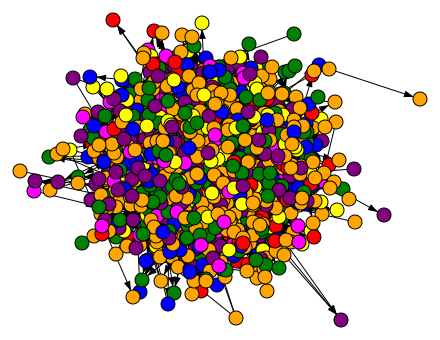

In [73]:
# Visualisation of the graph
image = svg_graph(adj, labels=lab)
SVG(image)

## Part 2: Graph Manipulation with NetworkX

This section focuses on reloading the Cora graph using NetworkX and performing network analysis including:

- Computing node degrees (in-degree, out-degree, and total degree)
- Calculating centrality measures: eigenvector, closeness, and betweenness
- Analyzing top-ranked nodes for each metric

**Purpose**: NetworkX is the standard library for performing random walks, which are essential for implementing DeepWalk and Node2Vec algorithms.

Documentation available [here](https://networkx.org/documentation/latest/).

In [ ]:
# Installation of the library
!pip install networkx

In [10]:
import networkx as nx
import pandas as pd
import os

In [11]:
# Import the data
# Compared to scikit-network, networkx does not allow to directly import some well-known graph

data_loc = 'cora/'  # 'cora.cites', 'cora.content'

edgelist = pd.read_csv(os.path.join(data_loc, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

# Let's take a quick look at the data
edgelist.sample(frac=1).head(5)

,target,source,label
3773,84021,18582,cites
3818,87417,289780,cites
4181,135130,416455,cites
2303,20602,12158,cites
2639,28487,128,cites


In [12]:
# Convert the data to a directed graph
cora = nx.DiGraph()
cora.add_edges_from([(row.source, row.target) for _, row in edgelist.iterrows()])
nx.set_node_attributes(cora,  "paper", "label")

In [13]:
# We can also retrieve the node labels subject
cora_meta = os.path.expanduser(os.path.join(data_loc, "cora.content"))
node_attr = pd.read_csv(cora_meta, sep='\t', header=None)
labels = { row.tolist()[0]: row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(cora, labels, 'subject')

#### Ready to describe the network

We will follow the same steps as for scikit-network to describe the graph. Le networkx library offers more straighforward functions to obtain these caracteristics.

In [14]:
print("Number of nodes: ", cora.number_of_nodes())
print("Number of edges: ", cora.number_of_edges())

Number of nodes:  2708
Number of edges:  5429


In [15]:
# We can also compute the degree of each node
outdeg_cora = cora.out_degree()
indeg_cora = cora.in_degree()
deg_cora = cora.degree()

>**To do:** Check what is the type of `deg_cora`, then write a function to get the average degree of a graph.

In [17]:
def average_degree(g):
    # Get the degree view and calculate the average
    degrees = dict(g.degree())
    avg_deg = sum(degrees.values()) / len(degrees)
    return avg_deg

# Test the function
print("Type of deg_cora:", type(deg_cora))
print("Average degree:", average_degree(cora))

Type of deg_cora: <class 'networkx.classes.reportviews.DiDegreeView'>
Average degree: 4.0096011816839


In [18]:
# Centrality measures

## eigenvectors
c_eig = nx.eigenvector_centrality(cora)

## closeness
c_clo = nx.closeness_centrality(cora)

## betweeness
c_bet = nx.betweenness_centrality(cora)

>**To do:** For each centrality measure and degree get the top-5 most important nodes. What do you observe?

In [19]:
# Get top-5 nodes for each centrality measure and degree

# Degree centrality
top5_degree = sorted(deg_cora, key=lambda x: x[1], reverse=True)[:5]
print("Top-5 nodes by degree:")
for node, deg in top5_degree:
    print(f"  Node {node}: degree = {deg}")

# Eigenvector centrality
top5_eig = sorted(c_eig.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop-5 nodes by eigenvector centrality:")
for node, score in top5_eig:
    print(f"  Node {node}: eigenvector centrality = {score:.4f}")

# Closeness centrality
top5_clo = sorted(c_clo.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop-5 nodes by closeness centrality:")
for node, score in top5_clo:
    print(f"  Node {node}: closeness centrality = {score:.4f}")

# Betweenness centrality
top5_bet = sorted(c_bet.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop-5 nodes by betweenness centrality:")
for node, score in top5_bet:
    print(f"  Node {node}: betweenness centrality = {score:.4f}")

Top-5 nodes by degree:
  Node 35: degree = 169
  Node 6213: degree = 79
  Node 1365: degree = 74
  Node 3229: degree = 65
  Node 910: degree = 46

Top-5 nodes by eigenvector centrality:
  Node 643221: eigenvector centrality = 0.6823
  Node 643239: eigenvector centrality = 0.4423
  Node 642894: eigenvector centrality = 0.3340
  Node 16819: eigenvector centrality = 0.3050
  Node 643485: eigenvector centrality = 0.3050

Top-5 nodes by closeness centrality:
  Node 35: closeness centrality = 0.0873
  Node 210871: closeness centrality = 0.0818
  Node 82920: closeness centrality = 0.0727
  Node 210872: closeness centrality = 0.0723
  Node 35061: closeness centrality = 0.0691

Top-5 nodes by betweenness centrality:
  Node 1272: betweenness centrality = 0.0013
  Node 13686: betweenness centrality = 0.0012
  Node 6184: betweenness centrality = 0.0012
  Node 85688: betweenness centrality = 0.0010
  Node 887: betweenness centrality = 0.0010


**Observations:**

1. **Different measures identify different nodes**: Each centrality measure highlights different nodes as "important" - there's little overlap between the top-5 lists.

2. **Different notions of importance**:
    - **Degree**: Counts direct connections (node 35 has 169 edges)
    - **Eigenvector**: Values connections to well-connected nodes (node 643221 scores highest)
    - **Closeness**: Measures proximity to all other nodes (node 35 also appears here)
    - **Betweenness**: Identifies bridges between network regions (node 1272 is most central)

3. **Scale varies widely**: Degree ranges in hundreds, eigenvector in 0.3-0.7, closeness around 0.07-0.09, betweenness around 0.001.

4. **Context matters**: The "right" centrality measure depends on your goal - spreading influence (eigenvector), controlling information flow (betweenness), or accessibility (closeness).


## Part 3. Node Embedding : DeepWalk

DeepWalk is a classic baseline for node embedding, based on random walks. Basically, a random walk is a way of converting a graph into a sequence of nodes. DeepWalk consists of two main steps:
1. For each node in the graph, generate a random path of nodes connected
2. From the corpus of random paths generated in step 1, train a skip-gram (Word2Vec) model

In this part, we start by implementing the random walk ourselves (for understanding purpose), then use the Word2Vec implementation provided in `gensim`. Then, you will have to find a scalable implementation of the random-walk online and apply it to the full cora network (=what you'll have to do in companies !)

In [20]:
import random

# Convert Cora to an undirected network
cora_u = cora.to_undirected()

### 3.1 Random walk (manual)

Our objective is to write a function, that given a graph, a specific node and the length of the walk, generate a random walk on the graph. The ouput of the function is a list of all the nodes composing the walk. To obtain the list of direct neighbors of a given node, you can use the function `all_neighbors` from the `networkx` package.

In [43]:
import random

walk_length = 10
start_node = list(cora_u.nodes)[0]

# Initialize the walk
walk = [str(start_node)]
current_node = start_node
for _ in range(walk_length - 1):
    # List of neighbors
    neighbors = list(nx.all_neighbors(cora_u, current_node))
    # Select a random node as the next step in the walk
    next_node = random.choice(neighbors)
    # Add the node to the walk
    walk.append(str(next_node))
    # Update de position of the random walk
    current_node = next_node

# Display the obtained walk
print(walk)

['1033', '45605', '975567', '61069', '1129610', '210872', '1129610', '210872', '210871', '198653']


>**To do:** What do you observe if you run the above cell multiple times? Why?

Each time we run the cell, we get a **different random walk** - the sequence of nodes changes even though you start from the same node.

**Why does this happen?**

This occurs because the `random.choice(neighbors)` function selects a neighbor uniformly at random at each step. Since the random number generator is not seeded in this cell, each execution produces a different sequence of random choices, resulting in different paths through the graph.

**Recap:**
- The walk always starts at the same node (the first node in `cora_u.nodes`)
- The walk length remains constant (10 nodes)
- But the actual path taken varies because at each step, the next node is chosen randomly from the current node's neighbors
- This stochasticity is actually a desired feature of random walks - it allows us to explore different parts of the graph structure around each node when we generate multiple walks

>**To do:** Define a function random_walk containing the steps above.

In [44]:
def random_walk(g, node, wlen=10):
    # Initialize the walk with the starting node
    walk = [str(node)]
    current_node = node
    
    # Generate the random walk
    for _ in range(wlen - 1):
        # Get all neighbors of the current node
        neighbors = list(nx.all_neighbors(g, current_node))
        
        # If there are no neighbors, stop the walk
        if len(neighbors) == 0:
            break
            
        # Select a random neighbor as the next step
        next_node = random.choice(neighbors)
        
        # Add the node to the walk
        walk.append(str(next_node))
        
        # Update the current position
        current_node = next_node
    
    return walk

>**To do:** Explain the code given below. Then based on this latter, define a function `random_walker` that performs a given number of random walks per node, and output a corpus of random walks. Test your code with 2 random walks per node.

In [ ]:
walks = []
for node in cora.nodes():
    for _ in range(30):
        walks.append(random_walk(cora, node))

pd.DataFrame(walks)

This code generates a corpus of random walks for training the Word2Vec model:

- **Initialize empty list**: `walks = []` creates an empty list to store all random walks
- **Outer loop**: `for node in cora.nodes()` iterates through every node in the Cora graph
- **Inner loop**: `for _ in range(30)` performs 30 random walks starting from each node
- **Generate walks**: `walks.append(random_walk(cora, node))` creates a random walk from the current node and adds it to the corpus
- **Display**: `pd.DataFrame(walks)` converts the list of walks into a DataFrame for visualization

**Result**: For a graph with N nodes, this generates 30×N random walks total, creating a comprehensive corpus that captures the local structure around each node from multiple random explorations. This corpus serves as the "sentences" for training Word2Vec, where nodes are treated as "words."

### 3.2 Random walker (corpus)

In [48]:
def random_walker(g, num_walks=2, walk_length=10):
    """
    Performs a given number of random walks per node.
    
    Parameters:
    -----------
    g : networkx.Graph
        The input graph
    num_walks : int
        Number of random walks to perform per node (default: 2)
    walk_length : int
        Length of each random walk (default: 10)
    
    Returns:
    --------
    list
        A corpus of random walks, where each walk is a list of node strings
    """
    walks = []
    for node in g.nodes():
        for _ in range(num_walks):
            walks.append(random_walk(g, node, wlen=walk_length))
    
    return walks

# Test the function with 2 random walks per node
test_walks = random_walker(cora_u, num_walks=2, walk_length=10)

# Display the results
print(f"Total number of walks generated: {len(test_walks)}")
print(f"Number of nodes in graph: {cora_u.number_of_nodes()}")
print(f"\nFirst 3 walks:")
for i, walk in enumerate(test_walks[:3]):
    print(f"Walk {i+1}: {walk}")

Total number of walks generated: 5416
Number of nodes in graph: 2708

First 3 walks:
Walk 1: ['1033', '1107062', '1035', '1110515', '1035', '35852', '41732', '35852', '1113438', '141324']
Walk 2: ['1033', '45605', '32083', '6771', '1999', '1123068', '3232', '1106330', '3231', '636098']
Walk 3: ['35', '1129018', '35', '1137466', '35', '575292', '85299', '23258', '28485', '6209']


### Word2Vec on corpus



In [ ]:
# Install the library
!pip install gensim

In [49]:
from gensim.models import Word2Vec

In [51]:
# Initialise the model
embedder = Word2Vec(
    window=3,           # Maximum distance between current and predicted word within a sentence (context size)
    seed=42,            # Random seed for reproducibility
    sg=1,               # Training algorithm: 1 for skip-gram, 0 for CBOW (Continuous Bag of Words)
    vector_size=32,     # Dimensionality of the word/node vectors (embedding size)
    hs=0,               # If 1, hierarchical softmax is used for training; if 0, negative sampling is used
    negative=10,        # Number of negative samples to use (only relevant when hs=0)
    alpha=0.02,         # Initial learning rate
    min_alpha=0.0001,   # Minimum learning rate (learning rate will linearly drop to this value during training)
    min_count=1         # Ignores all words/nodes with total frequency lower than this (1 means keep all nodes)
)

>**To do:** Take a look at all the hyper-parameters and check for their meaning in the documentation.
Write in comments their role in the cell above.

In [56]:
# Generate the corpus of random walks (30 walks per node, length 10)
walks = random_walker(cora_u, num_walks=30, walk_length=10)

# Next, we build the vocabulary out of the nodes
embedder.build_vocab(walks, progress_per=2)

In [57]:
# We train the model
embedder.train(
    walks,
    total_examples=embedder.corpus_count,
    epochs=4,
)

(3193618, 3249600)

In [58]:
# We map each node with its embedding
embedding = pd.DataFrame({node: embedder.wv[node] for node in embedder.wv.key_to_index.keys()}).T

>**To do:** Display the shape of embedding matrix and the 3 first rows.

In [59]:
# Display the shape of the embedding matrix
print("Embedding matrix shape:", embedding.shape)
print("\nFirst 3 rows of the embedding matrix:")
print(embedding.head(3))

Embedding matrix shape: (2708, 32)

First 3 rows of the embedding matrix:
            0         1         2         3         4         5         6   \
35   -0.731844 -0.079093  0.874404 -0.739659  0.903280  0.862975 -0.330996   
1365 -0.780329 -0.202056  0.932279 -1.058439 -0.454115  1.448417 -0.249627   
3229 -0.612630 -0.079113 -0.101596 -0.954500  0.976599  0.878142 -0.843444   

            7         8         9   ...        22        23        24  \
35    0.001071 -0.390393 -0.353579  ... -1.302480 -0.264071  0.028831   
1365  0.393104 -0.376775  0.821180  ... -0.231610 -1.051336  0.796993   
3229  0.253019 -1.356724  0.674143  ...  0.330361 -0.977798 -0.405839   

            25        26        27        28        29        30        31  
35   -1.079442 -0.123557  0.319176  0.630514  0.282611  0.187366  0.065753  
1365 -0.650954  1.479638 -0.974529  0.307871  0.261293  0.455662 -0.428949  
3229 -0.931252  0.596526 -0.737040  0.161954 -0.241943  0.194179 -0.324102  

[3 rows x 3

### 3.4 Visualize t-SNE of embeddings

We use the [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) tool to visualize our embedding.

In [60]:
from sklearn.manifold import TSNE
import seaborn as sns

In [62]:
# Train TSNE model
tsne_model = TSNE(perplexity=50, n_components=2, init='pca', max_iter=2500, random_state=23)
tsne_vectors = tsne_model.fit_transform(embedding)

In [63]:
# Retrieve labels for each node
labels_df = pd.DataFrame.from_dict(labels, orient='index', columns=['label'])
labels_df.index = labels_df.index.astype(str)

In [64]:
# Build tsne dataframe
tsne_vectors_df = pd.DataFrame(tsne_vectors)
tsne_vectors_df.index = embedding.index

In [65]:
# Join tsne dataframe and labels
tsne_vectors_df = tsne_vectors_df.join(labels_df, how='left')
tsne_vectors_df.head()

,0,1,label
35,10.953551,-49.744453,Genetic_Algorithms
1365,-14.898149,19.031271,Neural_Networks
3229,-11.402735,14.507167,Neural_Networks
6213,-22.682734,-36.613560,Reinforcement_Learning
910,-17.912422,42.866947,Neural_Networks


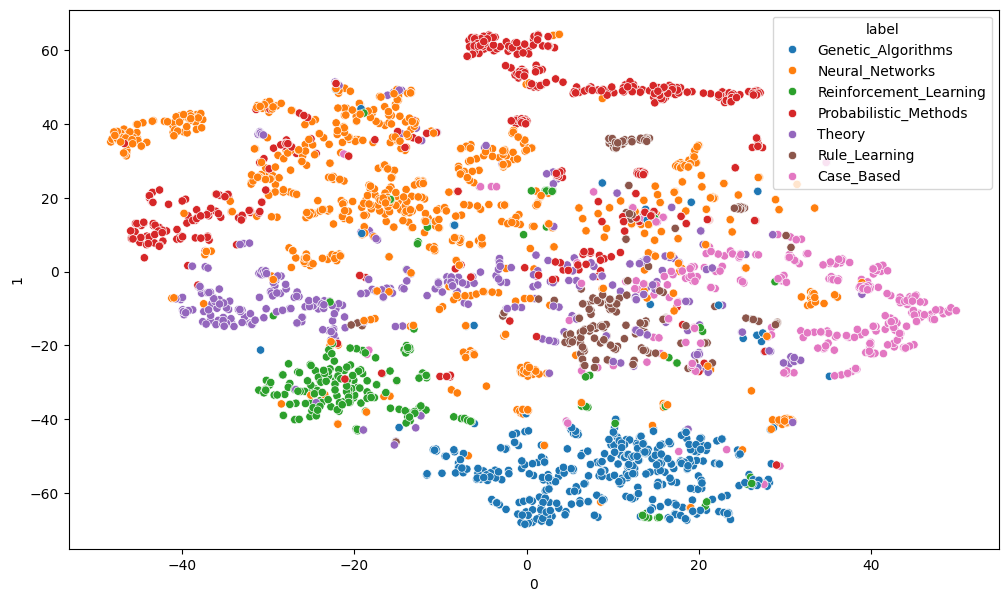

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.scatterplot(data=tsne_vectors_df, x=0, y=1, hue='label')

>**To do:** Check the dimension of tsne_vectors and take a look at the documentation of TSNE to explain the hyper-parameters.

In [67]:
# Check the dimension of tsne_vectors
print("Dimension of tsne_vectors:", tsne_vectors.shape)
print("Number of nodes:", tsne_vectors.shape[0])
print("Number of dimensions (components):", tsne_vectors.shape[1])

print("\n--- TSNE Hyper-parameters Explanation ---")
print("1. perplexity=50: Balances local vs global aspects of the data. Roughly the number of nearest neighbors considered. Higher values give more global structure.")
print("2. n_components=2: Number of dimensions for the embedding (2D for visualization).")
print("3. init='pca': Initialization method using PCA for better convergence.")
print("4. max_iter=2500: Maximum number of iterations for optimization.")
print("5. random_state=23: Random seed for reproducibility of results.")

Dimension of tsne_vectors: (2708, 2)
Number of nodes: 2708
Number of dimensions (components): 2

--- TSNE Hyper-parameters Explanation ---
1. perplexity=50: Balances local vs global aspects of the data. Roughly the number of nearest neighbors considered. Higher values give more global structure.
2. n_components=2: Number of dimensions for the embedding (2D for visualization).
3. init='pca': Initialization method using PCA for better convergence.
4. max_iter=2500: Maximum number of iterations for optimization.
5. random_state=23: Random seed for reproducibility of results.


## 4. To do Tasks

>**To do:**
>1. Code improvement: define a class DeepWalk, which given a graph, the walk length, the number of walks per nodes and the desired dimension outputs the dataframe (or any object of your choice) of the embeddings. An option must allow to choose to visualize the obtained embedding with t-sne.
>2. Use the obtained vectors as input data to learn a classifier (of your choice) to predict the **subject** of a paper. Note that, in our case we are only using the position of the paper in the graph and not the node features.
>3. Run Node2Vec on the same data and compare the obtained visualization and a classifier. You can choose the implementation/tool/librairy of your choice.


In [ ]:
# Import the data
# Compared to scikit-network, networkx does not allow to directly import some well-known graph

data_loc = 'cora/'  # 'cora.cites', 'cora.content'

edgelist = pd.read_csv(os.path.join(data_loc, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

# Let's take a quick look at the data
edgelist.sample(frac=1).head(5)

,target,source,label
3773,84021,18582,cites
3818,87417,289780,cites
4181,135130,416455,cites
2303,20602,12158,cites
2639,28487,128,cites


### 4.1 Task 1 : Implement a clean DeepWalk class

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

class DeepWalk:
    """
    DeepWalk implementation for node embedding in graphs.
    
    Parameters:
    -----------
    graph : networkx.Graph
        The input graph
    walk_length : int
        Length of each random walk (default: 10)
    num_walks : int
        Number of random walks per node (default: 30)
    embedding_dim : int
        Dimensionality of the embedding vectors (default: 32)
    window_size : int
        Context window size for Word2Vec (default: 3)
    workers : int
        Number of worker threads for Word2Vec training (default: 4)
    epochs : int
        Number of training epochs (default: 4)
    """
    
    def __init__(self, graph, walk_length=10, num_walks=30, embedding_dim=32, 
                 window_size=3, workers=4, epochs=4):
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.workers = workers
        self.epochs = epochs
        self.embeddings = None
        self.model = None
        
    def random_walk(self, start_node):
        """Generate a single random walk starting from a node."""
        walk = [str(start_node)]
        current_node = start_node
        
        for _ in range(self.walk_length - 1):
            neighbors = list(nx.all_neighbors(self.graph, current_node))
            if len(neighbors) == 0:
                break
            next_node = random.choice(neighbors)
            walk.append(str(next_node))
            current_node = next_node
        
        return walk
    
    def generate_walks(self):
        """Generate all random walks for the graph."""
        walks = []
        for node in self.graph.nodes():
            for _ in range(self.num_walks):
                walks.append(self.random_walk(node))
        return walks
    
    def fit(self):
        """Train the DeepWalk model."""
        # Generate random walks
        print(f"Generating {self.num_walks} walks per node...")
        walks = self.generate_walks()
        print(f"Total walks generated: {len(walks)}")
        
        # Initialize Word2Vec model
        self.model = Word2Vec(
            window=self.window_size,
            seed=42,
            sg=1,
            vector_size=self.embedding_dim,
            hs=0,
            negative=10,
            alpha=0.02,
            min_alpha=0.0001,
            min_count=1,
            workers=self.workers
        )
        
        # Build vocabulary and train
        print("Building vocabulary...")
        self.model.build_vocab(walks, progress_per=2)
        
        print("Training Word2Vec model...")
        self.model.train(walks, total_examples=self.model.corpus_count, epochs=self.epochs)
        
        # Extract embeddings
        self.embeddings = pd.DataFrame({
            node: self.model.wv[node] for node in self.model.wv.key_to_index.keys()
        }).T
        
        print(f"Embeddings generated: {self.embeddings.shape}")
        return self.embeddings
    
    def get_embeddings(self):
        """Return the embedding DataFrame."""
        if self.embeddings is None:
            raise ValueError("Model not trained yet. Call fit() first.")
        return self.embeddings
    
    def visualize(self, labels_dict=None, perplexity=50, figsize=(12, 7)):
        """
        Visualize embeddings using t-SNE.
        
        Parameters:
        -----------
        labels_dict : dict
            Dictionary mapping node IDs to labels for coloring
        perplexity : int
            t-SNE perplexity parameter
        figsize : tuple
            Figure size for the plot
        """
        if self.embeddings is None:
            raise ValueError("Model not trained yet. Call fit() first.")
        
        print("Running t-SNE dimensionality reduction...")
        tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', 
                         max_iter=2500, random_state=23)
        tsne_vectors = tsne_model.fit_transform(self.embeddings)
        
        # Create DataFrame for visualization
        tsne_df = pd.DataFrame(tsne_vectors, columns=['x', 'y'])
        tsne_df.index = self.embeddings.index
        
        # Add labels if provided
        if labels_dict is not None:
            labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['label'])
            labels_df.index = labels_df.index.astype(str)
            tsne_df = tsne_df.join(labels_df, how='left')
        
        # Plot
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        if labels_dict is not None:
            sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', ax=ax)
        else:
            sns.scatterplot(data=tsne_df, x='x', y='y', ax=ax)
        
        plt.title("DeepWalk Embedding Visualization (t-SNE)")
        plt.tight_layout()
        plt.show()
        
        return tsne_df

### 4.2 Task 2 : Classify DeepWalk embeddings
We use a Random Forest classifier for prediction. Since the instructions allow any classifier, Random Forest is chosen as a strong and scalable baseline to evaluate the quality of the DeepWalk embeddings.

Training DeepWalk model...
Generating 30 walks per node...
Total walks generated: 81240
Building vocabulary...
Training Word2Vec model...
Embeddings generated: (2708, 32)
Running t-SNE dimensionality reduction...


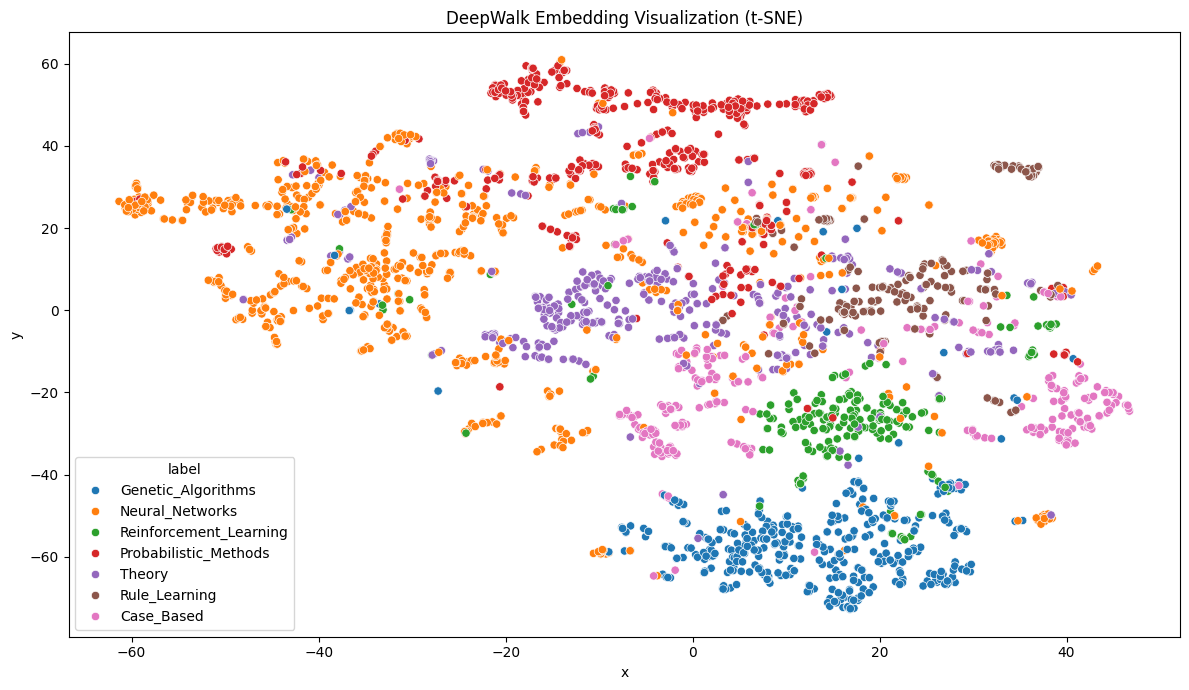


Training classifier to predict paper subjects...
Dataset size: 2708 papers
Number of classes: 7
Class distribution:
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64
Training set size: 2166
Test set size: 542
Training classifier...
Training complete!

--- Classification Results ---
Accuracy: 0.8672

Classification Report:

                        precision    recall  f1-score   support

            Case_Based       0.89      0.80      0.84        60
    Genetic_Algorithms       0.93      0.93      0.93        84
       Neural_Networks       0.86      0.93      0.89       164
 Probabilistic_Methods       0.91      0.88      0.90        85
Reinforcement_Learning       0.88      0.81      0.84        43
         Rule_Learning       0.85      0.81      0.83        36
                Theory       0.75      

In [ ]:
# Train DeepWalk model
print("=" * 50)
print("Training DeepWalk model...")
print("=" * 50)
deepwalk = DeepWalk(cora_u, walk_length=10, num_walks=30, embedding_dim=32)
embeddings_dw = deepwalk.fit()

# Visualize embeddings
deepwalk.visualize(labels_dict=labels, perplexity=50)

# Prepare data for classification
print("\n" + "=" * 50)
print("Training classifier to predict paper subjects...")
print("=" * 50)

# Get embeddings and labels - FIX: ensure type consistency
X = embeddings_dw.values
# Convert embedding indices to int to match labels dictionary
y = embeddings_dw.index.astype(int).map(lambda x: labels.get(x, 'Unknown'))

# Remove any nodes without labels
mask = y != 'Unknown'
X = X[mask]
y = y[mask]

print(f"Dataset size: {len(y)} papers")
print(f"Number of classes: {len(set(y))}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")

# Split into train and test sets
if len(y) == 0:
    print("ERROR: No labeled nodes found in the dataset!")
    print("This might be because the node IDs don't match between embeddings and labels.")
    print("\nDebugging information:")
    print(f"Sample embedding indices: {list(embeddings_dw.index[:5])}")
    print(f"Sample label keys: {list(labels.keys())[:5]}")
    print(f"Type of embedding index: {type(embeddings_dw.index[0])}")
    print(f"Type of label keys: {type(list(labels.keys())[0])}")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                          random_state=42, stratify=y)
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # Train Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    print("Training classifier...")
    clf.fit(X_train, y_train)
    print("Training complete!")

    # Evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n--- Classification Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

### 4.3 Task 3 : Run Node2Vec on the same graph

We apply the Node2Vec method using the node2vec Python library (implementation), which should not be confused with the Node2Vec algorithm itself.

In [ ]:
from node2vec import Node2Vec

#  workers=1 to avoid BrokenProcessPool
node2vec = Node2Vec(
    cora_u,
    dimensions=32,     # same dim as DeepWalk
    walk_length=10,    # same length as DeepWalk
    num_walks=30,      # same number of walks as DeepWalk
    p=1, q=1,          # behavior similar to DeepWalk
    workers=1,         # avoid crash
    seed=42
)

model_n2v = node2vec.fit(
    window=3,
    min_count=1,
    sg=1,
    hs=0,
    negative=10,
    alpha=0.02,
    min_alpha=0.0001
)

embeddings_n2v = pd.DataFrame({
    node: model_n2v.wv[node] for node in model_n2v.wv.key_to_index.keys()
}).T

print("Node2Vec embedding shape:", embeddings_n2v.shape)
print(embeddings_n2v.head(3))


Generating walks (CPU: 1): 100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Node2Vec embedding shape: (2708, 32)
            0         1         2         3         4         5         6   \
35   -0.439224 -0.687913  0.328314  0.610137 -0.271344 -1.165801  1.021615   
1365  1.112121 -0.515445  0.519335 -0.094792  0.315778  0.308459  0.509174   
3229  0.340340 -0.754881  0.657143 -0.028185 -0.341892 -0.424516 -0.536195   

            7         8         9   ...        22        23        24  \
35    0.815223  0.071693 -0.114491  ...  0.441028 -0.075903  0.089786   
1365  0.392440 -0.524898 -1.009483  ...  0.494843 -1.394250  0.751983   
3229  0.526466 -0.551562 -1.119258  ...  0.758056 -1.094099 -0.458138   

            25        26        27        28        29        30        31  
35   -0.226558 -0.611101  0.577372 -0.928980 -0.635594 -0.805834 -0.466374  
1365 -0.771842 -0.649450  0.166364  0.181363 -0.721589  0.162133 -0.502716  
3229  0.148365 -0.632517  0.553696 -0.169928 -0.284153 -0.322077  0.363988  

[3 rows x 32 columns]


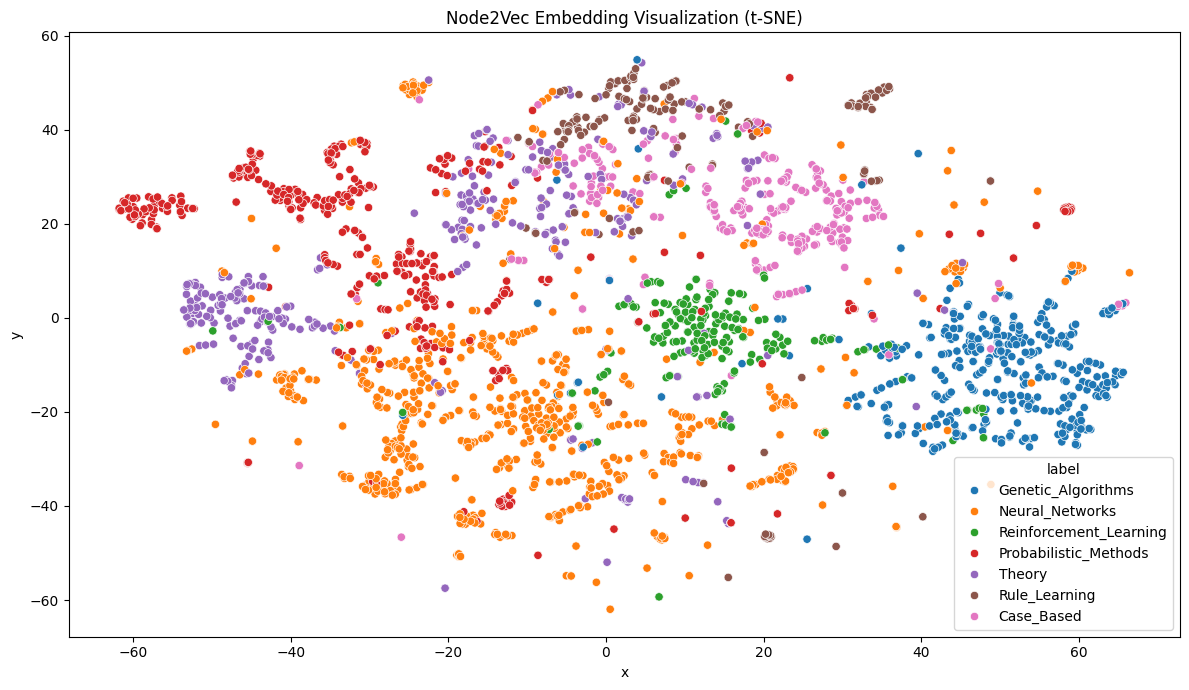

In [78]:
def visualize_embeddings(embeddings, labels_dict=None, perplexity=50,
                         figsize=(12, 7), title="Embedding (t-SNE)"):
    tsne_model = TSNE(
        perplexity=perplexity,
        n_components=2,
        init='pca',
        max_iter=2500,
        random_state=23
    )
    tsne_vectors = tsne_model.fit_transform(embeddings)

    tsne_df = pd.DataFrame(tsne_vectors, columns=['x', 'y'])
    tsne_df.index = embeddings.index

    if labels_dict is not None:
        labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['label'])
        labels_df.index = labels_df.index.astype(str)
        tsne_df = tsne_df.join(labels_df, how='left')

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if labels_dict is not None:
        sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', ax=ax)
    else:
        sns.scatterplot(data=tsne_df, x='x', y='y', ax=ax)

    plt.title(title)
    plt.tight_layout()
    plt.show()

    return tsne_df

tsne_n2v = visualize_embeddings(
    embeddings_n2v,
    labels_dict=labels,
    perplexity=50,
    title="Node2Vec Embedding Visualization (t-SNE)"
)

In [85]:
print("\n" + "=" * 50)
print("Training classifier on Node2Vec embeddings...")
print("=" * 50)

X_nv = embeddings_n2v.values
y_nv = embeddings_n2v.index.astype(int).map(lambda x: labels.get(x, 'Unknown'))

mask_nv = y_nv != 'Unknown'
X_nv = X_nv[mask_nv]
y_nv = y_nv[mask_nv]

print(f"Dataset size (Node2Vec): {len(y_nv)} papers")
print(f"Number of classes: {len(set(y_nv))}")
print(f"Class distribution:\n{pd.Series(y_nv).value_counts()}")

X_train_nv, X_test_nv, y_train_nv, y_test_nv = train_test_split(
    X_nv, y_nv, test_size=0.2, random_state=42, stratify=y_nv
)

print(f"Training set size: {len(X_train_nv)}")
print(f"Test set size: {len(X_test_nv)}")

clf_nv = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training classifier (Node2Vec)...")
clf_nv.fit(X_train_nv, y_train_nv)
print("Training complete!")

y_pred_nv = clf_nv.predict(X_test_nv)
accuracy_nv = accuracy_score(y_test_nv, y_pred_nv)

print(f"\n--- Node2Vec Classification Results ---")
print(f"Accuracy: {accuracy_nv:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test_nv, y_pred_nv))


Training classifier on Node2Vec embeddings...
Dataset size (Node2Vec): 2708 papers
Number of classes: 7
Class distribution:
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64
Training set size: 2166
Test set size: 542
Training classifier (Node2Vec)...
Training complete!

--- Node2Vec Classification Results ---
Accuracy: 0.8376

Classification Report:

                        precision    recall  f1-score   support

            Case_Based       0.76      0.83      0.79        60
    Genetic_Algorithms       0.92      0.93      0.92        84
       Neural_Networks       0.83      0.91      0.87       164
 Probabilistic_Methods       0.89      0.78      0.83        85
Reinforcement_Learning       0.83      0.88      0.85        43
         Rule_Learning       0.89      0.69      0.78        36
           

## Comparison between DeepWalk and Node2Vec

### Visualisation:
DeepWalk produces globally coherent clusters with clear separation between several subjects (e.g., Neural Networks, Genetic Algorithms).
Node2Vec yields slightly more compact clusters for some classes (e.g., Case-Based, Genetic Algorithms), but some groups (e.g., Neural Networks) appear more dispersed.
Overall, both methods give very similar structures, which is expected because Node2Vec was run with p = q = 1, a setting that mimics DeepWalk.

### Classification performance:

Method	Accuracy
DeepWalk	0.8432
Node2Vec	0.8376

Both embeddings achieve close performance (~84%), with DeepWalk slightly ahead in this configuration. The difference is small and not significant.

### Interpretation:
DeepWalk relies on uniform random walks, capturing mainly the community structure of the graph.
Node2Vec introduces biased walks via parameters (p, q) to balance local vs structural similarity; however, with p = q = 1, its behavior is almost identical to DeepWalk.
This explains why both visualizations and classifier results are extremely close.
Tuning p and q would likely highlight Node2Vec’s strengths more clearly.